In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline

In [3]:
from astromodal.config import load_config
from tqdm import tqdm
import polars as pl
import random
from pathlib import Path
from astromodal.datasets.datacubes import load_datacube_files

In [4]:
config = load_config("/home/schwarz/projetoFM/config.yaml")

hdd_folder = config['hdd_folder']

hddfolder = Path(config["hdd_folder"]) / "image_latents" 

In [5]:
file = config['datacubes_paths'].replace('*', 'STRIPE82-0002')

import polars as pl

header = pl.read_parquet(file, n_rows=0)
columns = [col for col in header.columns if 'gaiaxp' in col] + ["id", "mag_psf_r"]

In [6]:
train_files, val_files = load_datacube_files(config['datacubes_paths'], train_val_split=0.9, nfiles_subsample=500)

[info] - Found 2444 datacube files
[info] - Subsampled to 500 files
[info] - Training files: 450
[info] - Validation files: 50


In [7]:
train_df = None

for f in tqdm(train_files, desc="Loading train files"):
    try:
        df = pl.read_parquet(f, columns=columns, use_pyarrow=True)
        df = df.filter(pl.col(columns[0]).is_not_null())
        
        df = df.filter(pl.col("mag_psf_r") < 21)
        
        
        if df.height == 0:
            continue

        train_df = df if train_df is None else pl.concat([train_df, df], how="vertical", rechunk=False)
    except Exception as e:
        pass

val_df = None

for f in tqdm(val_files, desc="Loading val files"):
    try:
        df = pl.read_parquet(f, columns=columns, use_pyarrow=True)
        df = df.filter(pl.col(columns[0]).is_not_null())
        
        df = df.filter(pl.col("mag_psf_r") < 21)
        
        
        if df.height == 0:
            continue

        val_df = df if val_df is None else pl.concat([val_df, df], how="vertical", rechunk=False)
    except Exception as e:
        pass

Loading train files:   0%|          | 0/450 [00:00<?, ?it/s]

Loading val files: 100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


In [8]:
train_df = train_df.filter(pl.col("gaiaxp_solution_id").is_not_null())
val_df = val_df.filter(pl.col("gaiaxp_solution_id").is_not_null())

In [9]:
len(train_df), len(val_df)

(214515, 31507)

In [10]:
# rename columns, remove prefix gaiaxp_
train_df = train_df.rename(lambda x: x.replace('gaiaxp_', ''))
val_df = val_df.rename(lambda x: x.replace('gaiaxp_', ''))

In [11]:
import gaiaxpy
import tempfile
import os

import polars as pl

try: train_df = train_df.to_pandas()
except: pass
with tempfile.NamedTemporaryFile(suffix=".csv", delete=True) as tmp:
    train_df.to_csv(tmp.name)

    # gaiaxpy expects a path
    calibrated, sampling = gaiaxpy.calibrate(
        tmp.name,
        save_file=False
    )
    
calibrated = pl.from_pandas(calibrated)
train_df = pl.from_pandas(train_df)

# cast to i64
train_df = train_df.with_columns(
    pl.col("source_id").cast(pl.Int64)
)

train_df = train_df.join(calibrated, on="source_id", how="inner")

try: val_df = val_df.to_pandas()
except: pass
with tempfile.NamedTemporaryFile(suffix=".csv", delete=True) as tmp:
    val_df.to_csv(tmp.name)

    # gaiaxpy expects a path
    calibrated, sampling = gaiaxpy.calibrate(
        tmp.name,
        save_file=False
    )

calibrated = pl.from_pandas(calibrated)
val_df = pl.from_pandas(val_df)
# cast to i64
val_df = val_df.with_columns(
    pl.col("source_id").cast(pl.Int64)
)
val_df = val_df.join(calibrated, on="source_id", how="inner")



Text(0, 0.5, 'Flux')

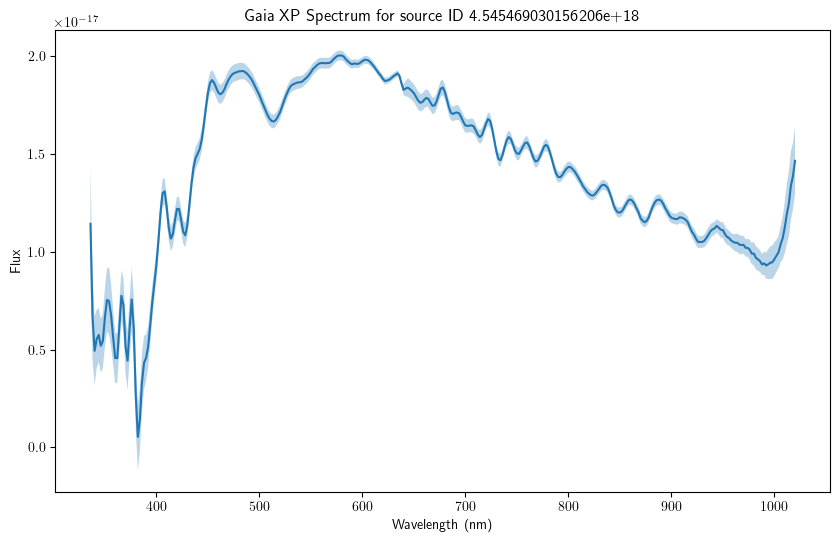

In [14]:
import numpy as np
import matplotlib.pyplot as plt

row = train_df.row(0, named=True)  # dict-like

flux = np.asarray(row["flux"]).squeeze()
err  = np.asarray(row["flux_error"]).squeeze()

plt.figure(figsize=(10, 6))
plt.plot(sampling, flux)
plt.fill_between(sampling, flux - err, flux + err, alpha=0.3)

# use the correct id column name (see below)
plt.title(f"Gaia XP Spectrum for source ID {row.get('solution_id', row.get('source_id', row.get('id', 'UNKNOWN')))}")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux")

In [23]:
from astromodal.datasets.desi_spectra import stitch_desi_arms
from astromodal.models.scaler1d import StandardScaler1D

from typing import Optional
import numpy as np

def fit_standard_scaler_1d_from_gaia_df(
    df,
    *,
    max_rows: Optional[int] = 50000,
    seed: int = 0,
    transform: str = "asinh",      # "none" or "asinh"
    asinh_scale: float = 1.0,      # tune if you want (e.g. 1, 10, median abs flux, etc.)
    clip_quantile: float = 0.999,  # clip extremes before mean/std
) -> StandardScaler1D:
    """
    Fit a 1D StandardScaler on Gaia XP flux values pooled across objects.
    Uses your stitch_desi_arms to get flux + mask; then aggregates values.

    Note: this reads rows and stitches, so it's heavier than reading a simple float column.
    Use max_rows to subsample.
    """
    import random

    rng = random.Random(seed)
    n = df.height
    idxs = list(range(n))
    if max_rows is not None and n > max_rows:
        idxs = rng.sample(idxs, k=max_rows)

    vals = []

    for idx in idxs:
        row = df.row(idx, named=True)
        vals.append(np.asarray(row["flux"]).squeeze())

    if not vals:
        raise ValueError("No valid rows found to fit scaler.")

    v = np.concatenate(vals)
    v = v[np.isfinite(v)]
    if v.size == 0:
        raise ValueError("No valid rows found to fit scaler.")

    # apply pre-transform
    if transform == "asinh":
        v = np.arcsinh(v / (asinh_scale if asinh_scale > 0 else 1.0))

    # optional clipping
    if 0.0 < clip_quantile < 1.0 and v.size > 10:
        lo = np.quantile(v, 1.0 - clip_quantile)
        hi = np.quantile(v, clip_quantile)
        v = np.clip(v, lo, hi)

    mean = float(np.mean(v))
    std = float(np.std(v))
    print(f"Fitted StandardScaler1D: mean={mean:.6g}, std={std:.6g}")
    if not np.isfinite(std) or std < 1e-6:
        std = 1.0

    return StandardScaler1D(mean=mean, std=std, transform=transform, asinh_scale=asinh_scale)

In [34]:
scaler = fit_standard_scaler_1d_from_gaia_df(train_df, max_rows=50000)

Fitted StandardScaler1D: mean=2.55635e-17, std=7.9414e-17


In [ ]:
scaler

In [30]:
scaler = StandardScaler1D.load(Path(config['models_folder']) / "gaiaxp_flux_scaler.npz")

In [33]:
scaler.save(Path(config['models_folder']) / "gaiaxp_flux_scaler.npz")

In [16]:
# random 30000 rows 
subset_df = train_df.sample(n=5000, seed=42)

In [18]:
from astromodal.datasets.gaiaxp import GaiaXPCalibratedDataset, gaiaxp_collate_pad_flux_only
from torch.utils.data import DataLoader

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ds_train = GaiaXPCalibratedDataset(
    subset_df,
    scaler_path=None,
    flux_col="flux",
    err_col="flux_error",
    return_stats=False,
)
dl_train = DataLoader(
    ds_train,
    batch_size=256,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=gaiaxp_collate_pad_flux_only,
)

ds_val = GaiaXPCalibratedDataset(
    val_df,
    flux_col="flux",
    err_col="flux_error",
    return_stats=False,
)
dl_val = DataLoader(
    ds_val,
    batch_size=256,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=gaiaxp_collate_pad_flux_only,
)
    

In [19]:
import torch
import numpy as np

batch = next(iter(dl_train))

# unpack (your collate returns x_pad, mask_pad, w_pad, lengths?)
if len(batch) == 4:
    x, mask, w, lengths = batch
elif len(batch) == 3:
    x, mask, w = batch
    lengths = None
else:
    raise RuntimeError(f"Unexpected batch format: {len(batch)}")

print("=== SHAPES ===")
print("x:", x.shape, x.dtype)
print("mask:", mask.shape, mask.dtype)
print("w:", w.shape, w.dtype)
if lengths is not None:
    print("lengths:", lengths.shape, lengths.dtype)

# move to cpu just in case
x = x.cpu()
mask = mask.cpu()
w = w.cpu()

print("\n=== X STATS (normalized flux) ===")
print("mean:", x.mean().item())
print("std:", x.std().item())
print("abs-mean:", x.abs().mean().item())
print("max abs:", x.abs().max().item())

print("\n=== MASK ===")
print("valid pixels:", int(mask.sum().item()), "/", mask.numel())
print("fraction valid:", mask.float().mean().item())

print("\n=== WEIGHTS ===")
print("mean w:", w.mean().item())
print("max w:", w.max().item())
print("min w:", w[w > 0].min().item() if (w > 0).any() else "NO POSITIVE W")
print("w>0 count:", int((w > 0).sum().item()))

print("\n=== EFFECTIVE WEIGHTED SCALE ===")
# what actually contributes to loss
eff = (x**2 * w.unsqueeze(-1)).sum() / (w.sum().clamp_min(1e-12))
print("E[x^2 weighted]:", eff.item())
print("sqrt:", eff.sqrt().item())

=== SHAPES ===
x: torch.Size([256, 343, 1]) torch.float32
mask: torch.Size([256, 343]) torch.bool
w: torch.Size([256, 343]) torch.float32
lengths: torch.Size([256]) torch.int64

=== X STATS (normalized flux) ===
mean: 3.0553752265605945e-17
std: 1.5188673202341953e-16
abs-mean: 3.0568439684562436e-17
max abs: 3.0351926416541213e-15

=== MASK ===
valid pixels: 87808 / 87808
fraction valid: 1.0

=== WEIGHTS ===
mean w: 1.0
max w: 1.0
min w: 1.0
w>0 count: 87808

=== EFFECTIVE WEIGHTED SCALE ===
E[x^2 weighted]: 2.40028467355104e-32
sqrt: 1.5492851998123833e-16


In [17]:
from astromodal.tokenizers.spectralrvq import SpectralPatchRVQ
from astromodal.tokenizers.rvq import ResidualVQ

In [ ]:
P = 8          # patch_size
C = 1          # channels in x (e.g., flux+ivar)
D = P * C      # <- MUST match RVQ dim (here D=8)

rvq = ResidualVQ(dim=D, num_stages=3, codebook_size=2048, decay=0.99).to(device)
srvq = SpectralPatchRVQ(rvq=rvq, patch_size=P, channels=C).to(device)

for i in range(10): 
    out = srvq.train_epoch(dl_train, device=device)
    print(out['loss'])

0.0023695225715637206
5.6409904408769593e-33
4.7309492732384364e-33
4.1101849868625654e-33


Exception ignored in: <function _afterFork at 0x7f23ce970680>
Traceback (most recent call last):
  File "/home/schwarz/miniconda3/lib/python3.13/logging/__init__.py", line 245, in _afterFork
    def _afterFork():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 2580468) exited unexpectedly

In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def _as_1d_float(x):
    if x is None:
        return np.empty(0, dtype=np.float64)
    a = np.asarray(x, dtype=np.float64)
    return np.ravel(a)

@torch.no_grad()
def run_one_object_gaiaxp_srvq_flux_only(
    row,
    srvq,                 # SpectralPatchRVQ
    scaler,               # StandardScaler1D (your class) with transform_x / inverse_transform_x
    device="cuda",
    *,
    flux_col="flux",
    flux_err_col="flux_error",   # optional, used only for mask + sigma residuals
    wave_col=None,               # optional
    plot=True,
    max_points=None,             # optional downsample for plotting speed
):
    srvq.eval().to(device)

    # -------------------------
    # 1) load arrays
    # -------------------------
    f = _as_1d_float(row.get(flux_col))
    if f.size == 0:
        return None

    fe = None
    if flux_err_col is not None:
        fe = _as_1d_float(row.get(flux_err_col))
        if fe.size == 0:
            fe = None

    if wave_col is not None and row.get(wave_col) is not None:
        w = _as_1d_float(row.get(wave_col))
    else:
        w = None

    # align lengths
    L = f.size
    if fe is not None:
        L = min(L, fe.size)
    if w is not None:
        L = min(L, w.size)

    f = f[:L]
    if fe is not None:
        fe = fe[:L]
    if w is not None:
        w = w[:L]

    # -------------------------
    # 2) mask
    # -------------------------
    mask = np.isfinite(f)
    if fe is not None:
        mask = mask & np.isfinite(fe) & (fe > 0)

    if not np.any(mask):
        return None

    # optional downsample (keeps alignment)
    if max_points is not None and L > max_points:
        idx = np.linspace(0, L - 1, int(max_points)).astype(int)
        f = f[idx]
        mask = mask[idx]
        if fe is not None:
            fe = fe[idx]
        if w is not None:
            w = w[idx]
        L = f.size

    # -------------------------
    # 3) normalize (GLOBAL scaler)
    # -------------------------
    f_norm = scaler.transform_x(f).astype(np.float32)  # [L]

    # srvq expects x [B,L,C]
    x = f_norm[:, None].astype(np.float32)             # [L,1]
    x_t = torch.from_numpy(x).unsqueeze(0).to(device=device, dtype=torch.float32)  # [1,L,1]

    # -------------------------
    # 4) quantize + decode
    # -------------------------
    enc = srvq.encode(x_t, update_ema=False)   # codes, x_q, etc.
    codes = enc["codes"]                       # [1,T,R]
    print(codes.shape)
    x_q = enc["x_q"]                           # [1,L,1] in normalized space

    # (optional) you can also test codes-only path:
    # x_q = srvq.decode(codes, L=L)            # [1,L,1]

    f_hat_norm = x_q[0, :, 0].detach().cpu().numpy().astype(np.float64)

    # -------------------------
    # 5) inverse transform to flux units
    # -------------------------
    f_hat = scaler.inverse_transform_x(f_hat_norm)

    resid = f_hat - f

    # sigma residuals (using flux_error as sigma)
    chi = None
    if fe is not None:
        chi = np.full_like(f, np.nan, dtype=np.float64)
        good = mask & np.isfinite(fe) & (fe > 0)
        chi[good] = resid[good] / fe[good]

    out = {
        "wave": w,
        "flux": f,
        "flux_hat": f_hat,
        "mask": mask.astype(bool),
        "resid": resid,
        "chi": chi,             # None if no flux_err_col
        "codes": codes.detach().cpu(),  # [1,T,R]
        "x_norm": f_norm,        # normalized input (for debugging)
        "xhat_norm": f_hat_norm, # normalized recon (for debugging)
    }

    # -------------------------
    # 6) plot
    # -------------------------
    if plot:
        m = out["mask"]
        xaxis = w if w is not None else np.arange(L)
        xlabel = "Wavelength" if w is not None else "Index"

        nrows = 4 if chi is not None else 3
        fig, axes = plt.subplots(nrows, 1, figsize=(12, 3.2 * nrows), sharex=True, gridspec_kw={"hspace": 0.35})

        axes[0].plot(xaxis[m], f[m], lw=1)
        axes[0].set_ylabel("Flux")
        axes[0].set_title("Original (GaiaXP)")

        axes[1].plot(xaxis[m], f_hat[m], lw=1)
        axes[1].set_ylabel("Flux")
        axes[1].set_title("Reconstruction (srvq)")

        axes[2].plot(xaxis[m], resid[m], lw=1)
        axes[2].axhline(0.0, ls="--", lw=0.8, alpha=0.7)
        axes[2].set_ylabel("dFlux")
        axes[2].set_xlabel(xlabel)
        axes[2].set_title("Residual (srvq - original)")

        if chi is not None:
            good = m & np.isfinite(chi)
            axes[3].plot(xaxis[good], chi[good], lw=1)
            axes[3].axhline(0.0, ls="--", lw=0.8, alpha=0.7)
            axes[3].axhline(+1.0, ls=":", lw=0.8, alpha=0.5)
            axes[3].axhline(-1.0, ls=":", lw=0.8, alpha=0.5)
            axes[3].axhline(+3.0, ls=":", lw=0.8, alpha=0.5)
            axes[3].axhline(-3.0, ls=":", lw=0.8, alpha=0.5)
            axes[3].set_ylabel("Residual / sigma")
            axes[3].set_xlabel(xlabel)
            axes[3].set_title("Residual in sigma units (using flux_error)")

        plt.tight_layout()
        plt.show()

    return out

torch.Size([1, 43, 3])


/tmp/ipykernel_2554785/2260186142.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


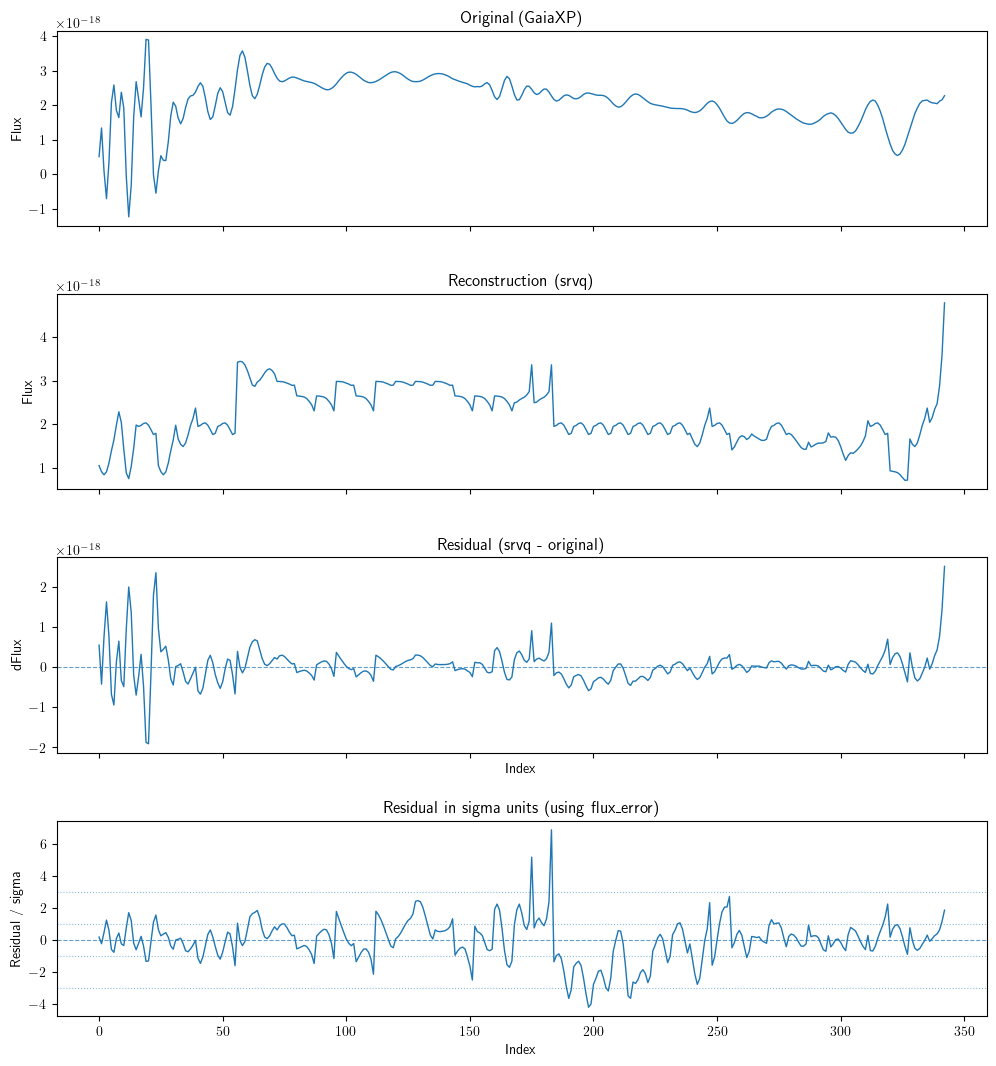

In [28]:
import random
row = train_df.row(random.randint(0, train_df.height - 1), named=True)

out = run_one_object_gaiaxp_srvq_flux_only(
    row,
    srvq=srvq,
    scaler=scaler,
    device="cuda",
    flux_col="flux",
    flux_err_col="flux_error",
    wave_col=None,
    plot=True,
)

In [35]:
from astromodal.models.gaiaxp_autoencoder import SpectraAutoEncoder

model = SpectraAutoEncoder(
    latent_dim=16,
    base_channels=32,
    num_down=4
)

model = model.to('cuda')

opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)

for epoch in range(10):
    tr = model.train_epoch(dl_train, opt, device)
    va = model.validate(dl_val, device)  # replace with val loader if you have one
    print(epoch, tr, va)

0 0.000948206830760418 1.0992560861699613e-06


1 3.871974747340953e-06 7.884628141482247e-07


KeyboardInterrupt: 

In [ ]:
from pathlib import Path
model.save(Path(config['models_folder']) / "spectra_autoencoder_gaiaxp.pth")

In [41]:
import numpy as np
import torch

# reuse the same robust normalization helpers you already use
# (if these are in astromodal.datasets.desi_spectra, keep that import;
# otherwise copy them from your utils)

@torch.no_grad()
def run_one_object_gaiaxp_ae_flux_only(
    row,
    model,
    device="cuda",
    *,
    flux_col="gaiaxp_flux",              # <- change to your column name
    flux_err_col="gaiaxp_flux_error",    # <- change to your column name (optional)
    wave_col=None,                       # <- set if you have wavelengths per row; else None
):
    """
    GaiaXP version of your DESI reconstruction plot helper.

    Expects in `row`:
      - flux_col: list/array length L
      - flux_err_col: list/array length L (optional)
      - wave_col: list/array length L (optional)

    Returns dict with flux, recon flux, mask, mu, sigma, latent.
    """

    model.eval().to(device)

    # --------------------------------------------------
    # 1) extract GaiaXP arrays
    # --------------------------------------------------
    f = row.get(flux_col, None)
    
    if f is None:
        return None
    f = np.asarray(f, dtype=np.float64).ravel()

    if f.size == 0:
        return None

    # wavelength (optional)
    if wave_col is not None and row.get(wave_col) is not None:
        w = np.asarray(row.get(wave_col), dtype=np.float64).ravel()
        L = min(f.size, w.size)
        f = f[:L]
        w = w[:L]
    else:
        w = None

    # error (optional) just to build a stricter mask if you want
    fe = None
    if flux_err_col is not None and row.get(flux_err_col) is not None:
        fe = np.asarray(row.get(flux_err_col), dtype=np.float64).ravel()
        L = min(f.size, fe.size)
        f = f[:L]
        fe = fe[:L]
        if w is not None:
            w = w[:L]

    # --------------------------------------------------
    # 2) build mask (valid pixels)
    # --------------------------------------------------
    mask = np.isfinite(f)
    if fe is not None:
        mask = mask & np.isfinite(fe) & (fe > 0)

    if not np.any(mask):
        return None

    # --------------------------------------------------
    # 3) SAME per-spectrum normalization as training
    # --------------------------------------------------
        # 3) normalize (GLOBAL standardization)
    f_norm = scaler.transform_x(f).astype(np.float32)   # <- force float32

    # 4) model expects [B, L, 1]
    x = f_norm[:, None].astype(np.float32)              # <- force float32
    x_t = torch.from_numpy(x).unsqueeze(0).to(device=device, dtype=torch.float32)

    # --------------------------------------------------
    # 5) encode / decode
    # --------------------------------------------------
    z = model.encode(x_t)                                 # [1, latent_dim, T]
    print(z.shape)
    x_hat_norm = model.decode(z, L_out=x_t.shape[1])      # [1,L,1]
    f_hat_norm = x_hat_norm.squeeze(0).squeeze(-1).cpu().numpy()

    # --------------------------------------------------
    # 6) denormalize reconstruction
    # --------------------------------------------------
    f_hat = scaler.inverse_transform_x(f_hat_norm)

    return {
        "wave": w,                 # None if you don't provide wave_col
        "flux": f,
        "flux_hat": f_hat,
        "mask": mask.astype(bool),
        "latent": z.squeeze(0).cpu(),  # [latent_dim, T]
    }

torch.Size([1, 16, 22])
shapes: (343,) (343,) (343,)
mask true: 343 / 343
finite f: 343 finite f_hat: 343


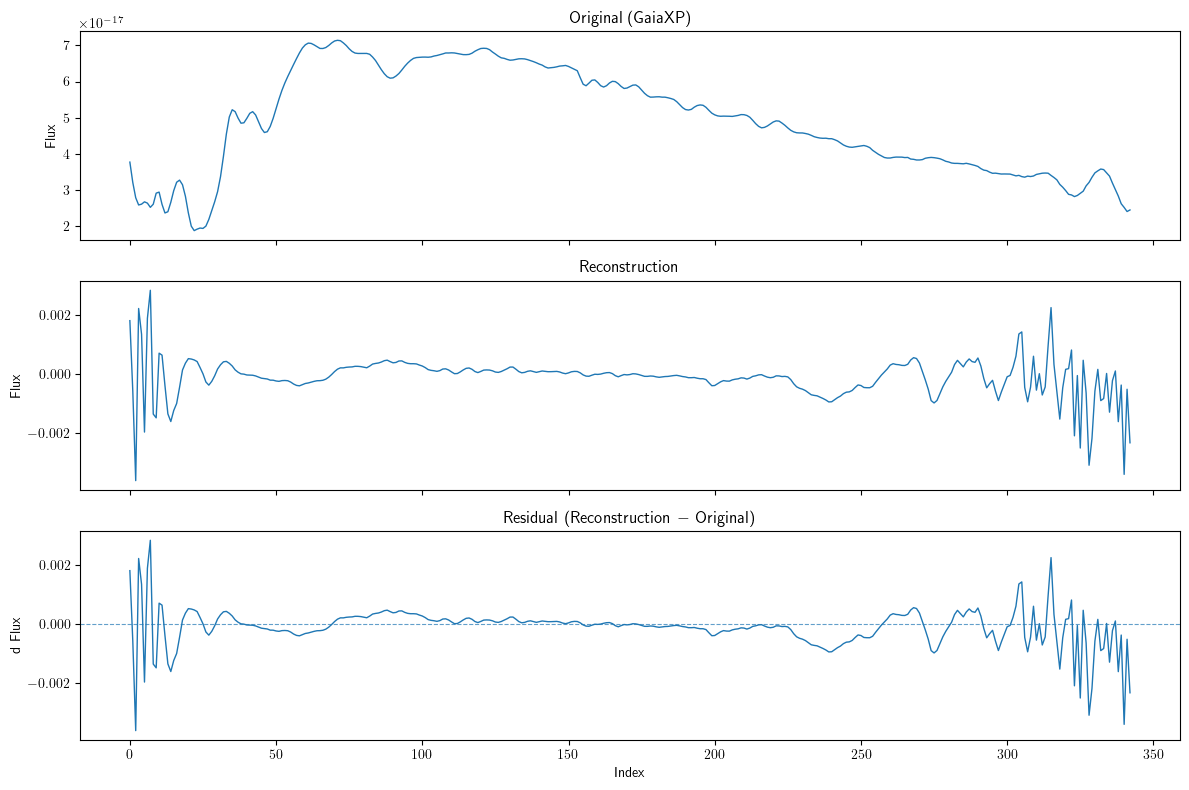

In [42]:
import numpy as np
import random
import matplotlib.pyplot as plt

row = train_df.row(random.randint(0, train_df.height - 1), named=True)

out = run_one_object_gaiaxp_ae_flux_only(
    row, model, device="cuda",
    flux_col="flux",
    flux_err_col="flux_error",
    wave_col=None,
)

if out is None:
    print("out is None")
else:
    def to_1d_np(a):
        # torch -> numpy
        try:
            import torch
            if isinstance(a, torch.Tensor):
                a = a.detach().float().cpu().numpy()
        except Exception:
            pass
        a = np.asarray(a)
        return np.squeeze(a)

    f     = to_1d_np(out["flux"])
    f_hat = to_1d_np(out["flux_hat"])
    m     = to_1d_np(out["mask"]).astype(bool)

    # sanity prints
    print("shapes:", f.shape, f_hat.shape, m.shape)
    print("mask true:", int(m.sum()), "/", m.size)
    print("finite f:", np.isfinite(f).sum(), "finite f_hat:", np.isfinite(f_hat).sum())

    # Fix shape mismatches if needed
    n = min(f.size, f_hat.size, m.size)
    f, f_hat, m = f[:n], f_hat[:n], m[:n]

    # If mask is empty, fall back to plotting all points
    if m.sum() == 0:
        print("Mask has 0 True values -> plotting all points.")
        m = np.ones(n, dtype=bool)

    resid = f_hat - f

    wave = out.get("wave", None)
    if wave is not None:
        x = to_1d_np(wave)[:n]
        xlabel = "Wavelength"
    else:
        x = np.arange(n)
        xlabel = "Index"

    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    axes[0].plot(x[m], f[m], lw=1)
    axes[0].set_ylabel("Flux")
    axes[0].set_title("Original (GaiaXP)")

    axes[1].plot(x[m], f_hat[m], lw=1)
    axes[1].set_ylabel("Flux")
    axes[1].set_title("Reconstruction")

    axes[2].plot(x[m], resid[m], lw=1)
    axes[2].axhline(0.0, ls="--", lw=0.8, alpha=0.7)
    axes[2].set_ylabel("d Flux")
    axes[2].set_xlabel(xlabel)
    axes[2].set_title("Residual (Reconstruction − Original)")

    plt.tight_layout()
    plt.show()

In [38]:
import polars as pl
from tqdm import tqdm

import numpy as np
import torch

@torch.no_grad()
def encode_one_row_flux_only(row: dict, model, device="cuda"):
    """
    row: dict-like with DESI arrays (from polars row(named=True))
    returns:
      z_np: np.ndarray [latent_dim, T]  (float32)
      or None if empty spectrum
    """
    w, f, iv, mask = stitch_desi_arms(
        row.get("desi_wave_b"), row.get("desi_flux_b"), row.get("desi_ivar_b"),
        row.get("desi_wave_r"), row.get("desi_flux_r"), row.get("desi_ivar_r"),
        row.get("desi_wave_z"), row.get("desi_flux_z"), row.get("desi_ivar_z"),
    )
    if f.size == 0:
        return None

    mask = mask.astype(bool)

    # SAME normalization as training
    stats = robust_flux_stats(f, mask)
    f_norm = normalize_flux(f, stats).astype(np.float32)

    # model expects [B,L,1]
    x = torch.from_numpy(f_norm[:, None]).unsqueeze(0).to(device)  # [1,L,1]
    z = model.encode(x)  # [1, latent_dim, T]

    return z.squeeze(0).detach().float().cpu().numpy()  # [latent_dim, T]

def encode_df_to_latents_polars(df: pl.DataFrame, model, device="cuda", id_col="id") -> pl.DataFrame:
    model.eval().to(device)

    ids_out = []
    latents_out = []

    # iter_rows(named=True) is the simplest & safest for list columns
    for row in tqdm(df.iter_rows(named=True), total=df.height, desc="Encoding"):
        obj_id = row[id_col]
        z = encode_one_row_flux_only(row, model, device=device)
        if z is None:
            continue

        ids_out.append(obj_id)
        latents_out.append(z.reshape(-1).tolist())  # flatten latent_dim*T

    return pl.DataFrame(
        {
            id_col: ids_out,
            "latent": latents_out,  # List[float]
        }
    )

In [101]:
lat_df = encode_df_to_latents_polars(train_df, model, device="cuda", id_col="id")
print(lat_df)

Encoding:   0%|          | 166/162704 [00:00<10:13, 265.11it/s]

Encoding: 100%|██████████| 162704/162704 [09:19<00:00, 290.62it/s]


shape: (162_704, 2)
┌───────────────────┬─────────────────────────────────┐
│ id                ┆ latent                          │
│ ---               ┆ ---                             │
│ binary            ┆ list[f64]                       │
╞═══════════════════╪═════════════════════════════════╡
│ b"i06n01s040003U" ┆ [1.876337, -0.894627, … 0.0865… │
│ b"i06n01s040005K" ┆ [0.281962, 2.087185, … 0.32901… │
│ b"i06n01s040005U" ┆ [-2.487012, 1.023529, … -0.184… │
│ b"i06n01s040006C" ┆ [1.787815, 3.005459, … 0.41456… │
│ b"i06n01s040007A" ┆ [0.588818, -0.516254, … -0.309… │
│ …                 ┆ …                               │
│ b"i06s13s120110T" ┆ [4.63525, -0.418773, … -0.3331… │
│ b"i06s13s12011EW" ┆ [-0.091681, 0.366326, … 0.1041… │
│ b"i06s13s12011I3" ┆ [1.266137, -1.064715, … 0.4247… │
│ b"i06s13s12011U0" ┆ [0.804412, -0.127837, … 0.0907… │
│ b"i06s13s12011V1" ┆ [-0.117586, -2.601095, … 0.306… │
└───────────────────┴─────────────────────────────────┘


In [ ]:
from astromodal.datasets.desi_spectra import LatentsPolarsDataset, collate_latents_pad_to_patch_multiple
from torch.utils.data import DataLoader

# Example: your AE latent_dim was 16
LATENT_DIM = 16
P = 16  # patch_size for SpectralPatchRVQ

ds_lat = LatentsPolarsDataset(
    lat_df,
    id_col="id",
    latent_col="latent",
    latent_dim=LATENT_DIM,
    nested_layout="auto",  # works for flat or nested
)

loader_lat = DataLoader(
    ds_lat,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=lambda batch: collate_latents_pad_to_patch_multiple(batch, patch_size=P),
)

In [103]:
from astromodal.tokenizers.spectralrvq import SpectralPatchRVQ
from astromodal.tokenizers.rvq import ResidualVQ
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

P = 2
C = LATENT_DIM
D = P * C

rvq = ResidualVQ(dim=D, num_stages=3, codebook_size=1024, decay=0.99).to(device)
tok = SpectralPatchRVQ(rvq=rvq, patch_size=P, channels=C).to(device)

tok.train()
for epoch in range(20):
    stats = tok.train_epoch(loader_lat, device=device, update_ema=True)
    print(epoch, stats)

0 {'loss': 0.12302235884439723}
1 {'loss': 0.11120172519900241}
2 {'loss': 0.10889942919798265}
3 {'loss': 0.10817781845832108}
4 {'loss': 0.10782118214332596}
5 {'loss': 0.10762385136361483}
6 {'loss': 0.10748104562519316}
7 {'loss': 0.10734959822838631}
8 {'loss': 0.10726967961920762}
9 {'loss': 0.10720477604077082}
10 {'loss': 0.10713630148895324}
11 {'loss': 0.10709451040648138}
12 {'loss': 0.1070529623284067}
13 {'loss': 0.10702835844000107}
14 {'loss': 0.10700723175345908}
15 {'loss': 0.10697441478871188}
16 {'loss': 0.10695041944034239}
17 {'loss': 0.10693309971767255}
18 {'loss': 0.10691359502743544}
19 {'loss': 0.1069048159685338}


In [104]:
import numpy as np
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def run_full_chain_and_plot(
    row,
    ae_model,
    tok_model,
    device="cuda",
    *,
    plot=True,
    max_points=None,          # optionally downsample for faster plotting
):
    ae_model.eval().to(device)
    tok_model.eval().to(device)

    # -------------------------
    # 1) stitch
    # -------------------------
    w, f, iv, mask = stitch_desi_arms(
        row.get("desi_wave_b"), row.get("desi_flux_b"), row.get("desi_ivar_b"),
        row.get("desi_wave_r"), row.get("desi_flux_r"), row.get("desi_ivar_r"),
        row.get("desi_wave_z"), row.get("desi_flux_z"), row.get("desi_ivar_z"),
    )
    if f.size == 0:
        return None

    mask = mask.astype(bool)

    # optional plot downsample (keeps mask alignment)
    if max_points is not None and f.size > max_points:
        idx = np.linspace(0, f.size - 1, max_points).astype(int)
        w = w[idx]
        f = f[idx]
        mask = mask[idx]
        iv = iv[idx]

    # -------------------------
    # 2) normalize (same as training)
    # -------------------------
    stats = robust_flux_stats(f, mask)
    f_norm = normalize_flux(f, stats).astype(np.float32)

    x = torch.from_numpy(f_norm[:, None]).unsqueeze(0).to(device)  # [1,L,1]
    L = x.shape[1]

    # -------------------------
    # 3) AE encode/decode (normalized)
    # -------------------------
    z_ae = ae_model.encode(x)                                # [1, C_lat, T]
    xhat_ae_norm = ae_model.decode(z_ae, L_out=L)            # [1, L, 1]
    fhat_ae_norm = xhat_ae_norm[0, :, 0].detach().cpu().numpy()
    fhat_ae = denormalize_flux(fhat_ae_norm, stats)

    # latent sequence for tokenizer: [B, T, C_lat]
    z_seq = z_ae.transpose(1, 2).contiguous()               # [1, T, C_lat]
    T = z_seq.shape[1]
    C_lat = z_seq.shape[2]

    if hasattr(tok_model, "channels") and int(tok_model.channels) != int(C_lat):
        raise ValueError(
            f"Tokenizer channels={tok_model.channels} but AE latent_dim={C_lat}. "
            f"Instantiate tok with channels=latent_dim."
        )

    # -------------------------
    # 4) Tokenizer encode/decode in latent space
    # -------------------------
    enc_tok = tok_model.encode(z_seq, update_ema=False)
    codes = enc_tok["codes"]              # [1, T_tok, R]
    T_tok = int(enc_tok["T"])
    L_lat = int(enc_tok["L"])             # should equal T (latent length)

    zq_seq = tok_model.decode(codes, L=L_lat)     # [1, L_lat, C_lat]
    zq_seq = zq_seq[:, :T, :]                     # [1, T, C_lat] match AE z length

    # -------------------------
    # 5) Decode tokenizer-quantized latents back to flux (normalized->denorm)
    # -------------------------
    zq_ae = zq_seq.transpose(1, 2).contiguous()   # [1, C_lat, T]
    xhat_final_norm = ae_model.decode(zq_ae, L_out=L)  # [1, L, 1]
    fhat_final_norm = xhat_final_norm[0, :, 0].detach().cpu().numpy()
    fhat_final = denormalize_flux(fhat_final_norm, stats)

    # -------------------------
    # 6) residuals (flux units)
    # -------------------------
    resid_ae = fhat_ae - f
    resid_final = fhat_final - f
    resid_final_vs_ae = fhat_final - fhat_ae

    # -------------------------
    # 6b) residuals in sigma units (chi)
    # chi = (fhat - f) / sigma_noise = (fhat - f) * sqrt(ivar)
    # -------------------------
    chi_ae = np.full_like(f, np.nan, dtype=np.float64)
    chi_final = np.full_like(f, np.nan, dtype=np.float64)
    chi_final_vs_ae = np.full_like(f, np.nan, dtype=np.float64)

    good = mask & np.isfinite(iv) & (iv > 0)
    if np.any(good):
        s = np.sqrt(iv[good])
        chi_ae[good] = resid_ae[good] * s
        chi_final[good] = resid_final[good] * s
        chi_final_vs_ae[good] = resid_final_vs_ae[good] * s

    out = {
        "wave": w,
        "mask": mask,
        "ivar": iv,
        "flux": f,
        "flux_hat_ae": fhat_ae,
        "flux_hat_final": fhat_final,
        "resid_ae_minus_orig": resid_ae,
        "resid_final_minus_orig": resid_final,
        "resid_final_minus_ae": resid_final_vs_ae,
        "chi_ae_minus_orig": chi_ae,
        "chi_final_minus_orig": chi_final,
        "chi_final_minus_ae": chi_final_vs_ae,
        "latent_ae_ct": z_ae[0].detach().cpu().numpy(),      # [C_lat, T]
        "latent_tok_tc": zq_seq[0].detach().cpu().numpy(),   # [T, C_lat]
        "codes": codes.detach().cpu(),                       # [1, T_tok, R]
        "mu": stats.mu,
        "sigma": stats.sigma,                                # normalization sigma (NOT noise sigma)
    }

    # -------------------------
    # 7) plotting
    # -------------------------
    if plot:
        m = mask

        fig, axes = plt.subplots(
            5, 1, figsize=(12, 12), sharex=True,
            gridspec_kw={"hspace": 0.50}
        )

        axes[0].plot(w[m], f[m], lw=1)
        axes[0].set_ylabel("Flux")
        axes[0].set_title("Original (stitched)")

        axes[1].plot(w[m], fhat_ae[m], lw=1)
        axes[1].set_ylabel("Flux")
        axes[1].set_title("AE reconstruction")

        axes[2].plot(w[m], fhat_final[m], lw=1)
        axes[2].set_ylabel("Flux")
        axes[2].set_title("Final reconstruction (AE ∘ Tok ∘ AE)")

        axes[3].plot(w[m], resid_ae[m], lw=1, label="AE − Orig", alpha=0.5)
        axes[3].plot(w[m], resid_final_vs_ae[m], lw=1, label="Final − AE", alpha=0.5)
        axes[3].plot(w[m], resid_final[m], lw=1, label="Final − Orig", alpha=0.5)
        axes[3].axhline(0.0, ls="--", lw=0.8, alpha=0.7)
        axes[3].set_ylabel("Δ Flux")
        axes[3].set_title("Residuals (flux units)")
        axes[3].legend()

        # sigma-units residuals (chi)
        axes[4].plot(w[good], chi_ae[good], lw=1, label="(AE − Orig) / σ", alpha=0.6)
        axes[4].plot(w[good], chi_final_vs_ae[good], lw=1, label="(Final − AE) / σ", alpha=0.6)
        axes[4].plot(w[good], chi_final[good], lw=1, label="(Final − Orig) / σ", alpha=0.6)
        axes[4].axhline(0.0, ls="--", lw=0.8, alpha=0.7)
        axes[4].axhline(+1.0, ls=":", lw=0.8, alpha=0.5)
        axes[4].axhline(-1.0, ls=":", lw=0.8, alpha=0.5)
        axes[4].axhline(+3.0, ls=":", lw=0.8, alpha=0.5)
        axes[4].axhline(-3.0, ls=":", lw=0.8, alpha=0.5)
        axes[4].set_ylabel("Residual (σ units)")
        axes[4].set_xlabel("Wavelength")
        axes[4].set_title("Residuals in sigma units (χ), using DESI ivar")
        axes[4].legend()

        plt.tight_layout()
        plt.show()

    return out


/tmp/ipykernel_1830877/952695244.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


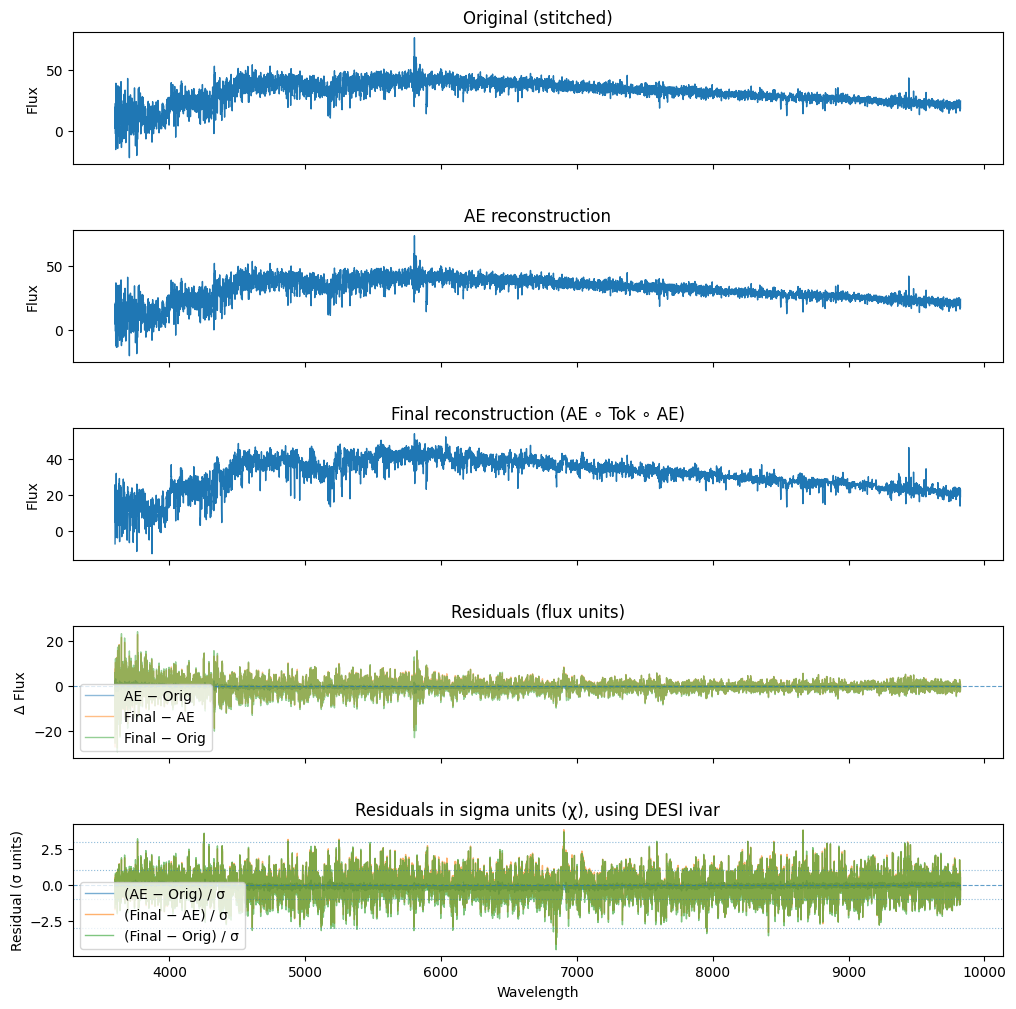

In [108]:
row = train_df.row(random.randint(0, train_df.height - 1), named=True)

out = run_full_chain_and_plot(
    row=row,
    ae_model=model,
    tok_model=tok,     # trained RVQ tokenizer over AE latents
    device="cuda",
    plot=True,
)

In [113]:
tok.save(Path(config['models_folder']) / "spectral_patch_rvq_desi.pth")

[info] - Saved SpectralPatchRVQ to /home/schwarz/projetoFM/outputs/spectral_patch_rvq_desi.pth
